## MA8701 Project 1

### Gunnar Grotmol, Petter Tinius Melbye and Casper Stenersen

In this report we have chosen to analyse the Facebook Comment Volume Dataset (https://archive.ics.uci.edu/ml/datasets/Communities+and+Crime?fbclid=IwAR1LxTCwJP5jyCXwcrWUa575xqqmIRLJ9fOcyLsP9mrwmC65N3DvWHEHT_I). Instances in this dataset contain features extracted from facebook posts. The task associated with the data is to predict how many comments the post will receive. 

The dataset contains 28 features and 40949 observations. We considered ridge, lasso and elastic net in order to deal with multicollinearity. However, we have focused on lasso for this exercise. 

In [278]:
#!pip install swiftviz
#!pip install mlxtend
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels.api as sm



from sklearn.linear_model import Lasso,LassoCV, lasso_path,LogisticRegression,LogisticRegressionCV 

import swiftviz as sv #pip install swiftviz
from mlxtend.plotting import plot_confusion_matrix

from sklearn.svm import l1_min_c
from time import time


sns.set_style("darkgrid")

In [325]:

def import_dataset(filename):
    return pd.read_csv(filename)

def regression_results(y_true, y_pred):
    import sklearn as sk 

    # Regression metrics
    explained_variance = sk.metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = sk.metrics.mean_absolute_error(y_true, y_pred) 
    mse = sk.metrics.mean_squared_error(y_true, y_pred) 
    #mean_squared_log_error = sk.metrics.mean_squared_log_error(y_true, y_pred)
    #median_absolute_error = sk.metrics.median_absolute_error(y_true, y_pred)
    r2=sk.metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
    #print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
   # print("median_absolute_error", round(median_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))


        

### Exploratory Analysis

In [292]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique() 
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

Let's take a quick look at what the data looks like:

In [293]:
df=pd.read_csv('Dataset.csv')
df.head()

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
0,634995,0,463.0,1.0,0.0,0,0.0,0,0,65,...,0,0,0,0.0,0,0,0,0,1,0
1,634995,0,463.0,1.0,0.0,0,0.0,0,0,10,...,0,0,0,0.0,0,0,0,1,0,0
2,634995,0,463.0,1.0,0.0,0,0.0,0,0,14,...,1,0,0,0.0,0,0,0,0,1,0
3,634995,0,463.0,1.0,7.0,0,3.0,7,-3,62,...,1,0,0,1.0,0,0,0,0,0,0
4,634995,0,463.0,1.0,1.0,0,0.0,1,0,58,...,0,0,0,0.0,0,1,0,0,0,0


In [300]:
df.columns

Index(['likes', 'Checkins', 'Returns', 'Category', 'commBase', 'comm24',
       'comm48', 'comm24_1', 'diff2448', 'baseTime', 'length', 'shares', 'hrs',
       'sun_pub', 'mon_pub', 'tue_pub', 'wed_pub', 'thu_pub', 'fri_pub',
       'sat_pub', 'sun_base', 'mon_base', 'tue_base', 'wed_base', 'thu_base',
       'fri_base', 'sat_base', 'output'],
      dtype='object')

Distribution graphs (histogram/bar graph) of sampled columns:

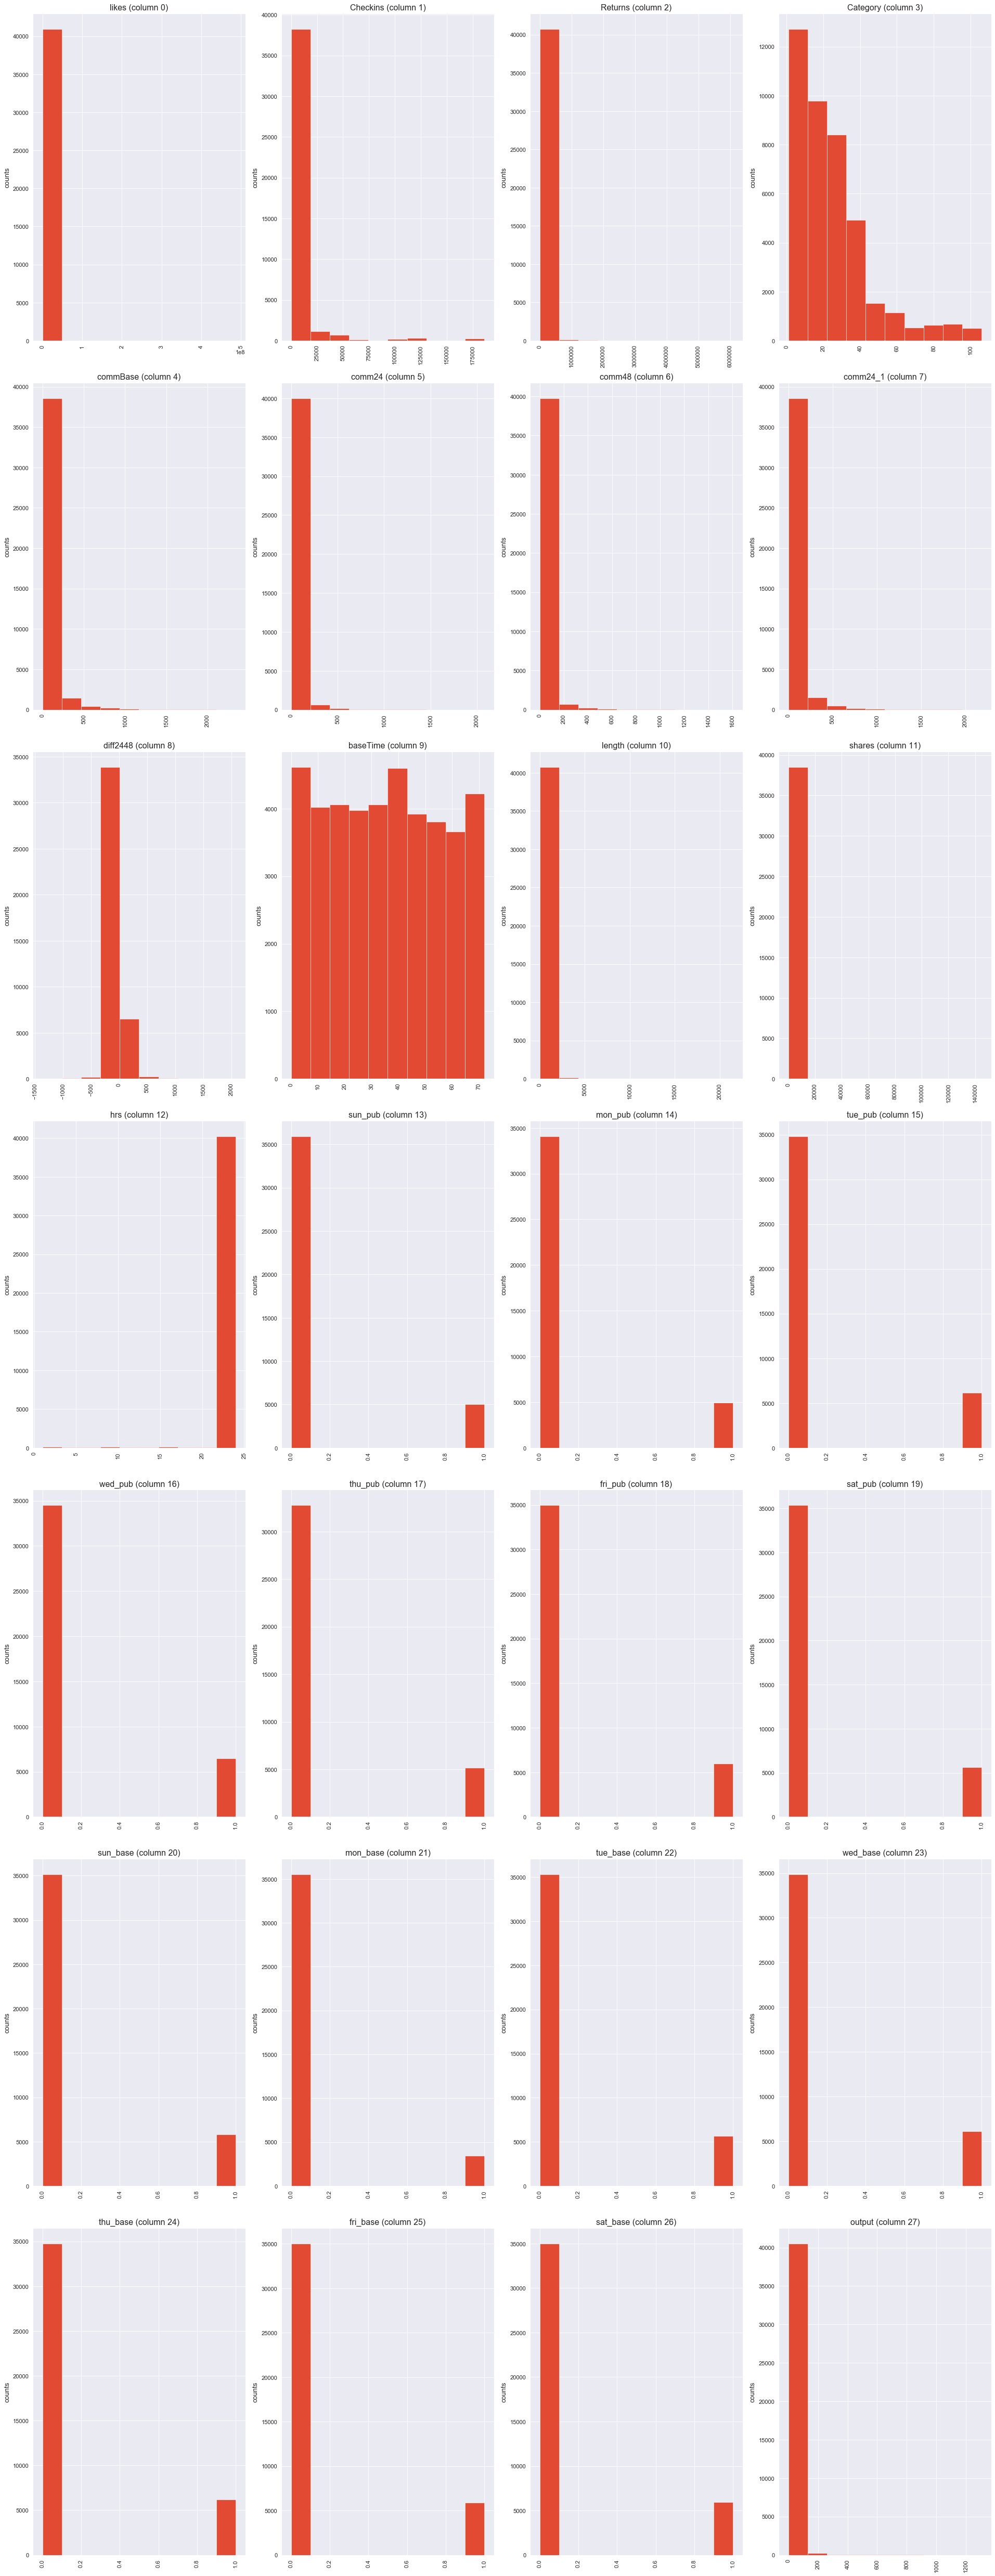

In [299]:
plotPerColumnDistribution(df, 28, 4)


Next we look at the properties of the different columns, with regard to minimum and maximum value, mean, standard deviation etc.

In [298]:
df.describe()

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
count,4.094900e+04,40949.000000,4.089800e+04,40892.000000,40889.000000,40949.000000,40901.00000,40949.000000,40949.000000,40949.000000,...,40949.000000,40949.000000,40949.000000,38979.000000,40949.000000,40949.000000,40949.000000,40949.000000,40949.000000,40949.000000
mean,1.313814e+06,4676.133752,4.485611e+04,24.272449,55.793783,22.186647,19.67260,52.631591,2.536961,35.322035,...,0.146157,0.136926,0.141640,0.088663,0.137635,0.148599,0.150846,0.143886,0.144888,7.322889
std,6.785752e+06,20593.184863,1.109917e+05,19.950812,137.062715,77.124263,71.11712,128.179920,94.202974,20.916864,...,0.353268,0.343774,0.348684,0.284261,0.344520,0.355698,0.357903,0.350979,0.351992,35.494550
min,3.600000e+01,0.000000,0.000000e+00,1.000000,0.000000,0.000000,0.00000,0.000000,-1366.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.673400e+04,0.000000,7.010000e+02,9.000000,2.000000,0.000000,0.00000,2.000000,-6.000000,17.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.929110e+05,0.000000,7.237000e+03,18.000000,11.000000,2.000000,0.00000,10.000000,0.000000,35.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.204214e+06,99.000000,5.141100e+04,32.000000,46.000000,12.000000,9.00000,44.000000,3.000000,53.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,4.869723e+08,186370.000000,6.089942e+06,106.000000,2341.000000,2079.000000,1605.00000,2184.000000,2079.000000,72.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1305.000000


Now we look at missing values. We replace the missing values with mean of column. 

In [296]:
tab_info=pd.DataFrame(df.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(df.isnull().sum()/df.shape[0]*100).T.rename(index={0:'null values (%)'}))
display(tab_info)

,likes,Checkins,Returns,Category,commBase,comm24,comm48,comm24_1,diff2448,baseTime,...,fri_pub,sat_pub,sun_base,mon_base,tue_base,wed_base,thu_base,fri_base,sat_base,output
column type,int64,int64,float64,float64,float64,int64,float64,int64,int64,int64,...,int64,int64,int64,float64,int64,int64,int64,int64,int64,int64
null values (nb),0,0,51,57,60,0,48,0,0,0,...,0,0,0,1970,0,0,0,0,0,0
null values (%),0,0,0.124545,0.139198,0.146524,0,0.117219,0,0,0,...,0,0,0,4.81086,0,0,0,0,0,0


Below we observe that columns with missing values are of type float64, and thus it is reasonable to replace missing values with column means. 

In [301]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   likes     40949 non-null  int64  
 1   Checkins  40949 non-null  int64  
 2   Returns   40898 non-null  float64
 3   Category  40892 non-null  float64
 4   commBase  40889 non-null  float64
 5   comm24    40949 non-null  int64  
 6   comm48    40901 non-null  float64
 7   comm24_1  40949 non-null  int64  
 8   diff2448  40949 non-null  int64  
 9   baseTime  40949 non-null  int64  
 10  length    40949 non-null  int64  
 11  shares    38500 non-null  float64
 12  hrs       40949 non-null  int64  
 13  sun_pub   40949 non-null  int64  
 14  mon_pub   39022 non-null  float64
 15  tue_pub   40949 non-null  int64  
 16  wed_pub   40949 non-null  int64  
 17  thu_pub   37904 non-null  float64
 18  fri_pub   40949 non-null  int64  
 19  sat_pub   40949 non-null  int64  
 20  sun_base  40949 non-null  in

## Fill missing values with column mean

In [302]:
# Firstly, we select numeric columns.
numeric = df.select_dtypes(include=np.number)
numeric_columns = numeric.columns
# Then, we fill the NaN values of numeric columns with the average value, given by the df.mean() function
df[numeric_columns] = df[numeric_columns].fillna(df.mean())
# Now, we can check whether the NaN values in numeric columns have been removed.
df[numeric_columns].isna().sum()/len(df)*100

likes       0.0
Checkins    0.0
Returns     0.0
Category    0.0
commBase    0.0
comm24      0.0
comm48      0.0
comm24_1    0.0
diff2448    0.0
baseTime    0.0
length      0.0
shares      0.0
hrs         0.0
sun_pub     0.0
mon_pub     0.0
tue_pub     0.0
wed_pub     0.0
thu_pub     0.0
fri_pub     0.0
sat_pub     0.0
sun_base    0.0
mon_base    0.0
tue_base    0.0
wed_base    0.0
thu_base    0.0
fri_base    0.0
sat_base    0.0
output      0.0
dtype: float64

In the plots below we plot the correlation matrix. To see how many were very correlated, a correlation matrix only showing the correlations above 0.7 was also plotted. We see that the perimeter 

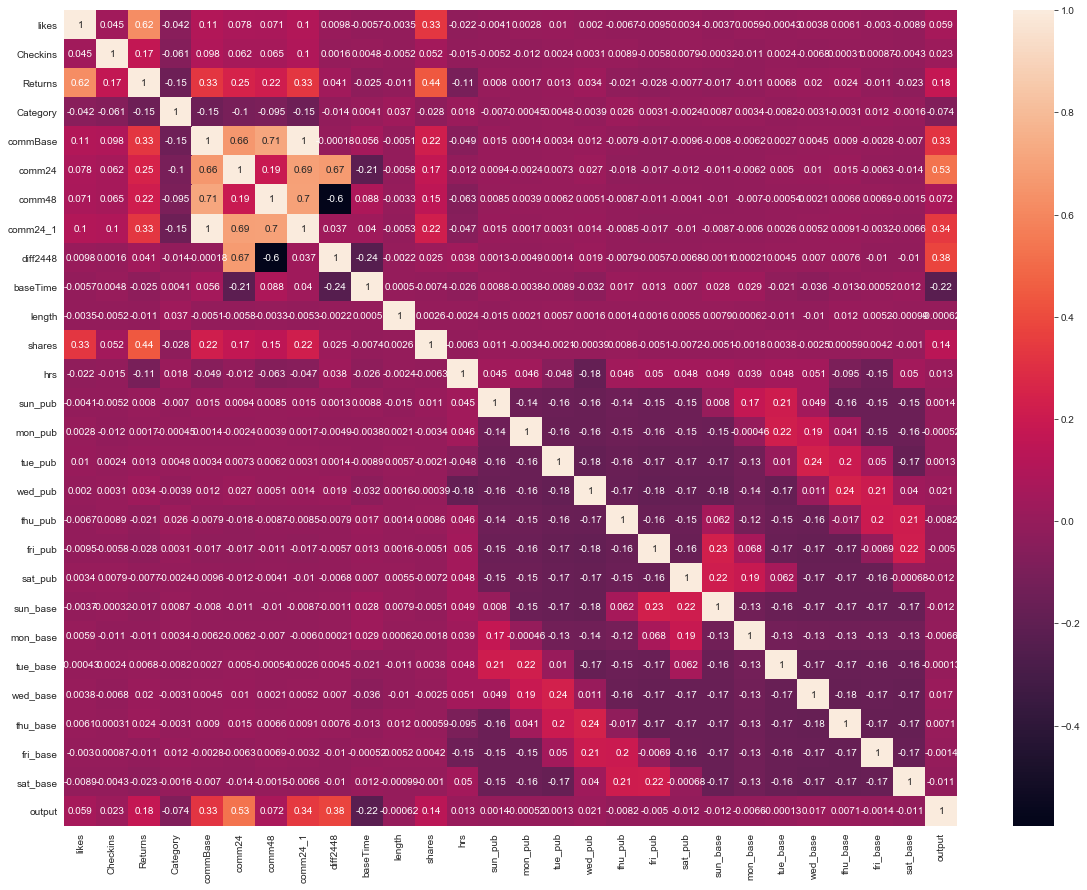

In [304]:
corr_matrix = df.corr()
fig, axs = plt.subplots(figsize=(20, 15))
sns.heatmap(corr_matrix, annot=True)

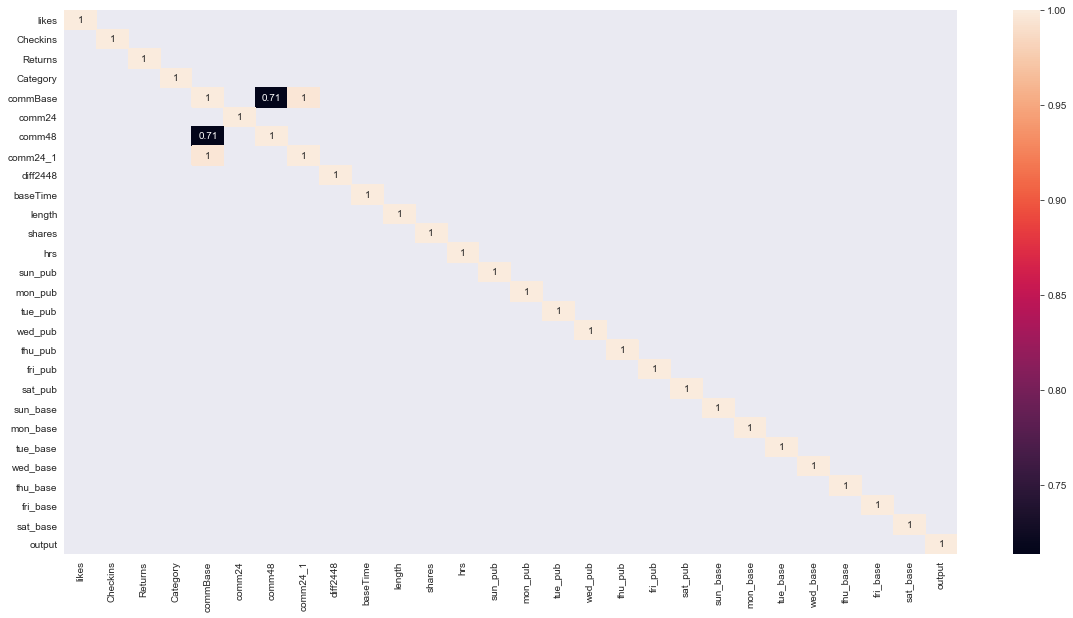

In [313]:
threshold = 0.7
cond_corr_matrix = corr_matrix[(corr_matrix > threshold) | (corr_matrix < -threshold)]


fig, axs = plt.subplots(figsize=(20, 10))
sns.heatmap(cond_corr_matrix, annot=True)

That is, there seems to be low correlation. However, we might try ridge, lasso or elastic net to remove variables.

## Analysis

It is important to standardize the features by removing the mean and scaling to unit variance. The L1 (Lasso) and L2 (Ridge) regularizers of linear models assume that all features are centered around 0 and have variance in the same order. If a feature has a variance that is orders of magnitude larger that others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected. Split the data set into train and test sets (use X_train, X_test, y_train, y_test), with the first 75% of the data for training and the remaining for testing

We will start by fitting a regular regression model, then look into different regularization techniques. First, the explanatory variables or scaled, so the same data set can be used for all methods.

In [192]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df.loc[:, df.columns != 'output'] = scaler.fit_transform(df.loc[:, df.columns != 'output'])

X = df.drop(['output'], axis=1)
y = df['output']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=10)
print(X_train.shape)
print(X_test.shape)

(30711, 27)
(10238, 27)


### Linear regression

We first fit a linear regression as bencmark. 

In [321]:
from statsmodels.api import OLS

#lm = LinearRegression(normalize=False, fit_intercept=True, n_jobs=-1)
model = OLS(y_train,X_train)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 output   R-squared (uncentered):                   0.288
Model:                            OLS   Adj. R-squared (uncentered):              0.288
Method:                 Least Squares   F-statistic:                              460.3
Date:                Sun, 14 Feb 2021   Prob (F-statistic):                        0.00
Time:                        16:13:20   Log-Likelihood:                     -1.4847e+05
No. Observations:               30711   AIC:                                  2.970e+05
Df Residuals:                   30684   BIC:                                  2.972e+05
Df Model:                          27                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
likes         -0.5243      0.230     -2.275      0.023      -0.976      -0.073
Checkins      -0.3855      0.177     -2.173      0.030      -0.733      -0.038
Returns        1.3908      0.251      5.544      0.000       0.899       1.883
Category      -0.7396      0.178     -4.151      0.000      -1.089      -0.390
commBase      23.1347      2.433      9.507      0.000      18.365      27.904
comm24        17.9065     20.096      0.891      0.373     -21.483      57.296
comm48        -0.8500     18.510     -0.046      0.963     -37.130      35.430
comm24_1     -23.4727      2.565     -9.151      0.000     -28.501     -18.445
diff2448       0.2523     24.533      0.010      0.992     -47.833      48.337
baseTime      -4.1458      0.186    -22.241      0.000      -4.511      -3.780
length         0.1977      0.173      1.143      0.253      -0.141       0.537
shares         1.6392      0.191      8.581      0.000       1.265       2.014
hrs            0.6930      0.176      3.930      0.000       0.347       1.039
sun_pub       -0.0527      0.371     -0.142      0.887      -0.779       0.674
mon_pub        0.1486      0.371      0.401      0.689      -0.578       0.875
tue_pub        0.2399      0.389      0.616      0.538      -0.523       1.003
wed_pub        0.4230      0.399      1.060      0.289      -0.359       1.205
thu_pub        0.2954      0.379      0.780      0.435      -0.447       1.038
fri_pub        0.4023      0.397      1.013      0.311      -0.376       1.181
sat_pub       -0.0442      0.390     -0.113      0.910      -0.808       0.719
sun_base      -0.6650      0.351     -1.897      0.058      -1.352       0.022
mon_base      -0.1645      0.302     -0.545      0.585      -0.756       0.427
tue_base      -0.5521      0.348     -1.585      0.113      -1.235       0.130
wed_base      -0.1958      0.372     -0.527      0.598      -0.925       0.533
thu_base      -0.6974      0.384     -1.815      0.070      -1.450       0.056
fri_base      -0.3958      0.377     -1.049      0.294      -1.135       0.343
sat_base      -0.6413      0.366     -1.750      0.080      -1.360       0.077
==============================================================================
Omnibus:                    61907.892   Durbin-Watson:                   1.860
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        266599922.876
Skew:                          16.547   Prob(JB):                         0.00
Kurtosis:                     458.244   Cond. No.                         392.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the c

In [326]:
reg = LinearRegression().fit(X_train, y_train)
ypred = reg.predict(X_test)
regression_results(y_test, ypred)

explained_variance:  0.2994
r2:  0.2993
MAE:  7.9145
MSE:  909.434
RMSE:  30.1568


## Lasso

The best_estimator_ belonging to GridSearchCV can be used to find the value of lambda yielding the highest MSE, but as we are interested in selecting as few predictors as possible for the final model and to obtain a better generalization performance, we apply the one-standard-error-rule. The following plot shows average MSE with 1sd bands for different values of lambda. 

The maximal penalty yielding nonzero coefficients for the lasso as implemented in sklearn is np.abs(X.T.dot(Y)).max() / len(X).

In [195]:
l1_min_c_ = np.abs(X.T.dot(y)).max() / len(X) 
l1_min_c_

18.765606820076083

In [327]:
lambdas = l1_min_c_ * np.logspace(0, -3.75, 60)

In [237]:
from sklearn.linear_model import Lasso, LinearRegression
from sklearn.model_selection import GridSearchCV


estimator = Lasso(tol=0.01)
param_grid = {"alpha" : lambdas}
param_grid


{'alpha': array([1.87656068e+01, 1.62107568e+01, 1.40037377e+01, 1.20971940e+01,
        1.04502174e+01, 9.02746893e+00, 7.79842106e+00, 6.73670234e+00,
        5.81953168e+00, 5.02722953e+00, 4.34279563e+00, 3.75154422e+00,
        3.24078894e+00, 2.79957061e+00, 2.41842211e+00, 2.08916520e+00,
        1.80473508e+00, 1.55902880e+00, 1.34677429e+00, 1.16341724e+00,
        1.00502340e+00, 8.68194140e-01, 7.49993549e-01, 6.47885419e-01,
        5.59678835e-01, 4.83481167e-01, 4.17657457e-01, 3.60795338e-01,
        3.11674733e-01, 2.69241669e-01, 2.32585669e-01, 2.00920213e-01,
        1.73565861e-01, 1.49935677e-01, 1.29522633e-01, 1.11888729e-01,
        9.66555996e-02, 8.34963897e-02, 7.21287449e-02, 6.23087521e-02,
        5.38257056e-02, 4.64975863e-02, 4.01671564e-02, 3.46985850e-02,
        2.99745342e-02, 2.58936409e-02, 2.23683423e-02, 1.93229966e-02,
        1.66922606e-02, 1.44196870e-02, 1.24565137e-02, 1.07606174e-02,
        9.29560941e-03, 8.03005546e-03, 6.93680079e-03,

In [238]:
n_folds = 10
cv = GridSearchCV(estimator, param_grid, cv=n_folds, scoring='neg_mean_squared_error')
cv.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.01, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([1.87656068e+01, 1.62107568e+01, 1.40037377e+01, 1.20971940e+01,
       1.04502174e+01, 9...
       5.38257056e-02, 4.64975863e-02, 4.01671564e-02, 3.46985850e-02,
       2.99745342e-02, 2.58936409e-02, 2.23683423e-02, 1.93229966e-02,
       1.66922606e-02, 1.44196870e-02, 1.24565137e-02, 1.07606174e-02,
       9.29560941e-03, 8.03005546e-03, 6.93680079e-03, 5.99238766e-03,
       5.17655197e-03, 4.47178852e-03, 3.86297533e-03, 3.33704922e-03])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=0)

In [242]:
scores = -cv.cv_results_['mean_test_score']
scores_std = cv.cv_results_['std_test_score']

best_lambd = cv.best_params_['alpha']

best_lambd

2.0891651959107507

In [240]:
#Code to find one sd rule lambda

index_best = np.argmax(cv.cv_results_['mean_test_score']) #index of best one
errorbest = -cv.cv_results_['mean_test_score'][index_best]
sdbest = cv.cv_results_['std_test_score'][index_best]

upper_bound = errorbest+sdbest

onesd = best_lambd #start at best and move to the left
erroronesd = errorbest
i = index_best

for j in range(len(lambdas)):
    i=i-1
    onesd= lambdas[i]
    erroronesd=  -cv.cv_results_['mean_test_score'][i]
    if erroronesd > upper_bound:
        i=i+1
        onesd= lambdas[i]
        erroronesd=  -cv.cv_results_['mean_test_score'][i]
        break


Text(0.5, 1.0, 'Confidence bands for mse')

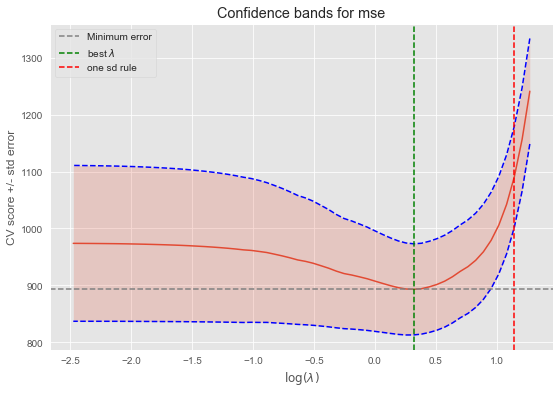

In [241]:
#plot
plt.figure(figsize=(9,6))
plt.plot(np.log10(lambdas), scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)
plt.plot(np.log10(lambdas), scores + std_error, 'b--')
plt.plot(np.log10(lambdas), scores - std_error, 'b--')

plt.fill_between(np.log10(lambdas), scores + std_error, scores - std_error, alpha=0.2)
plt.ylabel('CV score +/- std error')
plt.xlabel(r'$\log(\lambda)$')
plt.axhline(np.min(scores), linestyle='--', color='.5', label='Minimum error')
plt.axvline(np.log10(best_lambd) , linestyle='dashed', color='green', label='best '+r'$\lambda$')
plt.axvline(np.log10(onesd), linestyle='dashed', color='red', label='one sd rule')
plt.legend()
plt.title('Confidence bands for mse') 

We see green vertical line is best lambda and red is one standard error rule. We observe that average MSE decreases until $\lambda_{best}$ is reached. For larger lambda the shrinkage becomes dominant and forces all coefficient towards zero (hence increase in average mse).

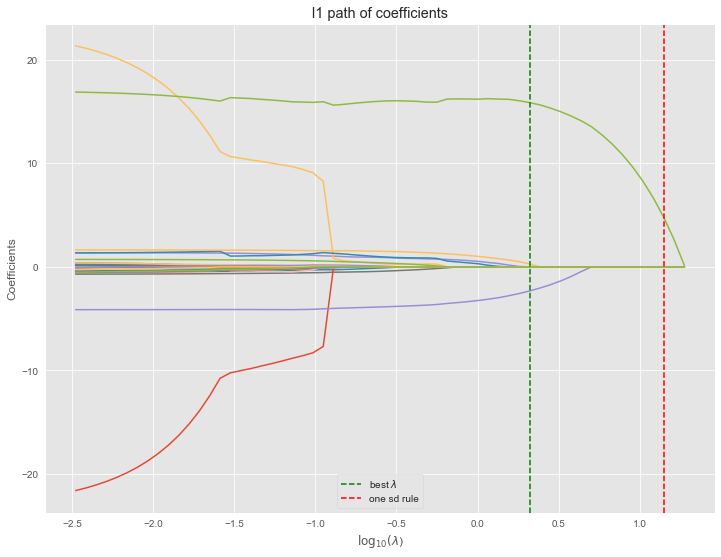

In [246]:
clf = Lasso(tol=0.01)
coefs_ = []

for alpha in lambdas:
    clf.set_params(alpha=alpha)
    clf.fit(X_train, np.ravel(y_train))
    coefs_.append(clf.coef_.ravel().copy())

coefs_ = np.array(coefs_)
plt.figure(figsize=(12,9))
plt.plot(np.log10(lambdas), coefs_) #proper value of lambda should be -np.log10(cs)
ymin, ymax = plt.ylim()
plt.xlabel(r'$\log_{10}(\lambda$)')
plt.ylabel('Coefficients')
plt.axvline(np.log10(best_lambd) , linestyle='dashed', color='green', label='best '+r'$\lambda$')
plt.axvline(np.log10(onesd), linestyle='dashed', color='red', label='one sd rule')
plt.legend()
plt.title('l1 path of coefficients')
plt.axis('tight')
plt.show()

## Best Lasso

In [247]:
best_lasso = cv.best_estimator_
print(best_lasso.coef_)

[ 0.         -0.          0.         -0.          0.         15.85523767
 -0.          0.          0.         -2.32610208  0.          0.28001238
  0.         -0.          0.          0.          0.         -0.
  0.         -0.         -0.          0.         -0.          0.
 -0.          0.         -0.        ]


In [248]:
np.sum(best_lasso.coef_ != 0)

3

In [249]:
np.where(best_lasso.coef_ != 0)[0]
index_best = best_lasso.coef_!=0
index_best

array([False, False, False, False, False,  True, False, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False])

In [250]:
np.where(best_lasso.coef_ == 0)[0]

array([ 0,  1,  2,  3,  4,  6,  7,  8, 10, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24, 25, 26])

In [251]:
X_test_best = X_test.loc[:,index_best]
X_test_best = sm.add_constant(X_test_best)

X_test_best
X_test.shape

(10238, 27)

In [252]:
results = sm.OLS(y_test, X_test_best).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.295
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     1429.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:54:16   Log-Likelihood:                -49432.
No. Observations:               10238   AIC:                         9.887e+04
Df Residuals:                   10234   BIC:                         9.890e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4873      0.299     25.042      0.0

## Onesd Lasso

In [253]:
onesd_lasso = Lasso()
onesd_lasso.set_params(alpha=onesd)
onesd_lasso.fit(X_train, np.ravel(y_train))


Lasso(alpha=14.003737735077253, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [254]:
print(onesd_lasso.coef_)

[ 0.          0.          0.         -0.          0.          4.78053788
  0.          0.          0.         -0.          0.          0.
  0.          0.          0.          0.          0.         -0.
 -0.         -0.         -0.         -0.          0.          0.
  0.         -0.         -0.        ]


In [255]:
np.sum(onesd_lasso.coef_ != 0)

1

In [256]:
np.where(onesd_lasso.coef_ != 0)[0]
index_onesd = onesd_lasso.coef_!=0
np.where(onesd_lasso.coef_ == 0)[0]

array([ 0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26])

Now that we have found a well-performing model using only 25 predictors, there are several options. One may for instance fit a logistic regression to the test set, using the variables selected by the lasso, to obtain parameter estimates and p-values. Another option is to do bootstrapping on the training data, and fit lasso several times. This will not yield p-values, but interesting information can still be obtained, for example the proportion of times a variable is set to zero. In the following sections, both approaches are tested, starting with bootstrapping.

In [257]:
X_test_onesd = X_test.loc[:,index_onesd]
X_test_onesd = sm.add_constant(X_test_onesd)

X_test_onesd.head(5)

,const,comm24
1549,1.0,-0.015386
12072,1.0,-0.261745
39913,1.0,-0.287678
14330,1.0,-0.209880
31783,1.0,6.999353


In [258]:
results = sm.OLS(y_test, X_test_onesd).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 output   R-squared:                       0.281
Model:                            OLS   Adj. R-squared:                  0.281
Method:                 Least Squares   F-statistic:                     4001.
Date:                Sun, 14 Feb 2021   Prob (F-statistic):               0.00
Time:                        14:54:40   Log-Likelihood:                -49534.
No. Observations:               10238   AIC:                         9.907e+04
Df Residuals:                   10236   BIC:                         9.909e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.4743      0.302     24.752      0.0

## Bootstrap Lasso

In [259]:
from random import choices
def BSlasso( X, y, lambdas, B=1000, n_folds=10):
    N = len(y)
    p = X.shape[1]
    coefs_matrix = np.zeros((B,p)) # Bxp - matrix, each row contains coefficient values for one bootstrap sample
    error_matrix = np.zeros((B, len(lambdas))) # Bx len(cs), matrix, each row contains the error for one bootstrap sample
    
    
    for b in range(B):
        # print(b)
        bootstrap_indexes = choices(np.arange(N),k=N) # sampling k=N indexes with replacement
        #print(bootstrap_indexes)
        X_boot = X.iloc[bootstrap_indexes,:]
        y_boot = y.iloc[bootstrap_indexes]

        #Cross validation for bootstrap sample
        estimator = Lasso(tol=0.1)
        param_grid = {"alpha" : lambdas}
        cv = GridSearchCV(estimator, param_grid, cv=n_folds, scoring='neg_mean_squared_error')
        cv.fit(X_boot, y_boot)

        coefs_matrix[b,:] = cv.best_estimator_.coef_
        error_matrix[b, :] = -cv.cv_results_['mean_test_score'] #we use the best lambda

    zero_elements = np.zeros(p) # is element of this list counts the relative number of times each elements coeff are zero
    for j in range(p):
        zero_elements[j] = 1-(np.count_nonzero(coefs_matrix[:,j])/B) #how many times ==0

    return coefs_matrix, error_matrix, zero_elements

In [260]:
bootstrap_size=20
coefs, errors, zeros= BSlasso(X_train, y_train, lambdas, B=bootstrap_size, n_folds=10)

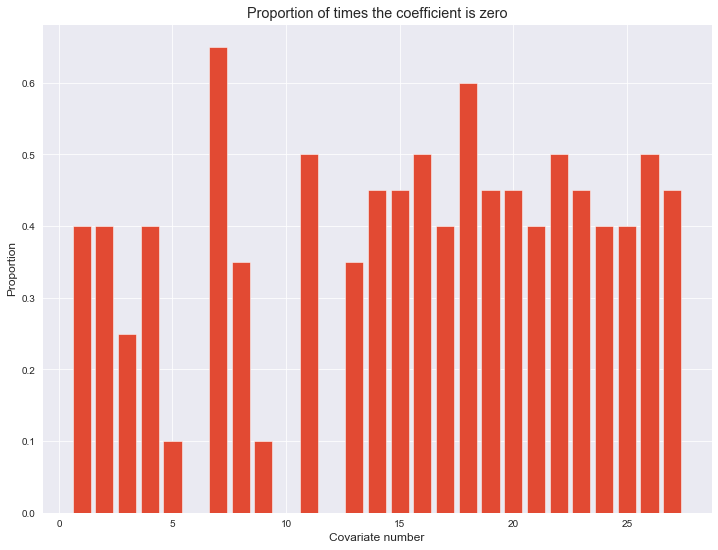

In [328]:
p = X_train.shape[1]
plt.figure(figsize=(12,9))
plt.bar(np.arange(1, p+1, 1), zeros)
plt.savefig("nonzero_coefs_B=%s.pdf" % bootstrap_size)
plt.title('Proportion of times the coefficient is zero') #proper title???
plt.xlabel('Covariate number')
plt.ylabel('Proportion')
plt.savefig('BSprops.png', dpi=500)
plt.show()

### Elastic net

In [105]:
from sklearn.linear_model import ElasticNet

alpha_values = np.array(list(map(lambda x: 1/10**x, np.arange(2,6))))
l1_ratio_values = np.arange(0, 0.1, 0.01)
param_grid = {"alpha" : alpha_values,
              "l1_ratio" : l1_ratio_values}
cv = GridSearchCV(ElasticNet(),
                 param_grid=param_grid, cv=5, n_jobs=-1)

cv.fit(x_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True,
                                  l1_ratio=0.5, max_iter=1000, normalize=False,
                                  positive=False, precompute=False,
                                  random_state=None, selection='cyclic',
                                  tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_grid={'alpha': array([1.e-02, 1.e-03, 1.e-04, 1.e-05]),
                         'l1_ratio': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [106]:
alpha_values

array([1.e-02, 1.e-03, 1.e-04, 1.e-05])

In [107]:
params = cv.best_params_
print(params)
cv.best_score_

{'alpha': 0.001, 'l1_ratio': 0.09}


0.31207290595201986

In [94]:
params['l1_ratio']

0.09

In [108]:
lm = ElasticNet(alpha = params['alpha'], l1_ratio = params['l1_ratio'])

lm.fit(x_train, y_train)

ElasticNet(alpha=0.001, copy_X=True, fit_intercept=True, l1_ratio=0.09,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [109]:
best_net = cv.best_estimator_
print(best_net.coef_)
y_pred = lm.predict(x_test)
mse = np.mean(np.power(y_test - y_pred, 2))
rmse = np.sqrt(mse)
print("MSE: {0} | RMSE: {1}".format(mse, rmse))

[ 28.40710629  77.95097338   2.46240277 -34.21174761  21.49678753
  20.92547027 -40.94894921  -4.22677553  -0.09152294  68.18157579
  -0.46539639   1.21743921 -16.59314439  40.30152454  -5.7155854
 -15.68854422   1.50977924 -16.88525018  -7.56861259   4.45812272
   0.91187544  33.35312801  19.68016675  -0.88922412   2.11212866
   9.95031527 -62.62327223  11.37356672  10.45112297   7.21482623
  -5.01506095  -1.15762383  -2.0932593  -26.65618844  42.46752564
   7.2477075 ]
MSE: 15840.41196906284 | RMSE: 125.85869842431566


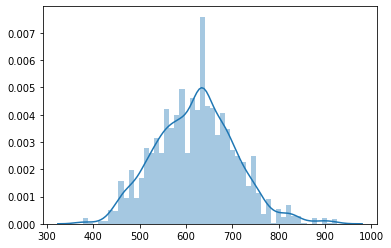

In [110]:
sns.distplot(y_pred,bins=50)